
# Name : **Shravanthi Balasubramanian**
# School :SCDS
# Email ID : *shravanthi.b-26@scds.saiuniversity.edu.in

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Car_Dataset.zip'
extract_path = '/content/Car_Dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: /content/Car_Dataset


In [ ]:
import shutil

source_dir = '/content/Car_Dataset/Car_Dataset'
train_dir = '/content/splits/train'
test_dir = '/content/splits/test'

if os.path.exists(source_dir):
    print("Source directory exists:", os.listdir(source_dir))
else:
    print("Source directory does not exist:", source_dir)

print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory
        # Create class folders in train and test directories if they don't exist
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Get all files in the current class directory
        all_files = os.listdir(class_path)  # <-- This was missing

        # Split files into train and test sets
        train_files, test_files = train_test_split(all_files, test_size=0.25, random_state=42)

        # Move files to the train directory
        for file in train_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(train_dir, class_name, file)
            if not os.path.exists(dst):  # Check if file already exists
                shutil.move(src, dst)

        # Move files to the test directory
        for file in test_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(test_dir, class_name, file)
            if not os.path.exists(dst):  # Check if file already exists
                shutil.move(src, dst)

Source directory exists: ['Toyota Innova', 'Mahindra Scorpio', 'Swift', 'Audi', 'Rolls Royce', 'Tata Safari', 'Hyundai Creta']
Train directory exists: False
Test directory exists: False


In [ ]:

#dataset prep
def prepare_data(source_dir):
    file_paths, labels = [], []
    classes = os.listdir(source_dir)
    for class_name in classes:
        class_folder = os.path.join(source_dir, class_name)
        if os.path.isdir(class_folder):
            for file in os.listdir(class_folder):
                file_paths.append(os.path.join(class_folder, file))
                labels.append(class_name)
    return file_paths, labels, classes

file_paths, labels, classes = prepare_data(source_dir)
num_classes = len(classes)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode= 'categorical',
    shuffle=False
)


num_classes = len(train_generator.class_indices)



Found 2811 images belonging to 7 classes.
Found 309 images belonging to 7 classes.
Found 1045 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

num_classes = len(train_generator.class_indices)

#base inceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#freeze
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)
output = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


checkpoint = ModelCheckpoint('/content/drive/MyDrive/InceptionResNetV2_TL.keras',
                             monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, early_stop]
)


model.save('/content/drive/MyDrive/InceptionResNetV2_TL_final.keras')
print("Model training complete. Best model saved.")

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.4612 - loss: 1.7932
Epoch 1: val_accuracy improved from -inf to 0.71521, saving model to /content/drive/MyDrive/InceptionResNetV2_TL.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 97s 737ms/step - accuracy: 0.4623 - loss: 1.7889 - val_accuracy: 0.7152 - val_loss: 0.8065
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7154 - loss: 0.8647
Epoch 2: val_accuracy improved from 0.71521 to 0.79612, saving model to /content/drive/MyDrive/InceptionResNetV2_TL.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - accuracy: 0.7155 - loss: 0.8645 - val_accuracy: 0.7961 - val_loss: 0.5962
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7671 - loss: 0.6872
Epoch 3: val_accuracy improved from 0.79612 to 0.85761, saving model to /content/drive/MyDrive/InceptionResNetV2_TL.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 17s 193ms/step - accuracy: 0.7672 - loss: 0.6872 - val_accuracy: 0.8576 - val_loss: 0.4513
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━

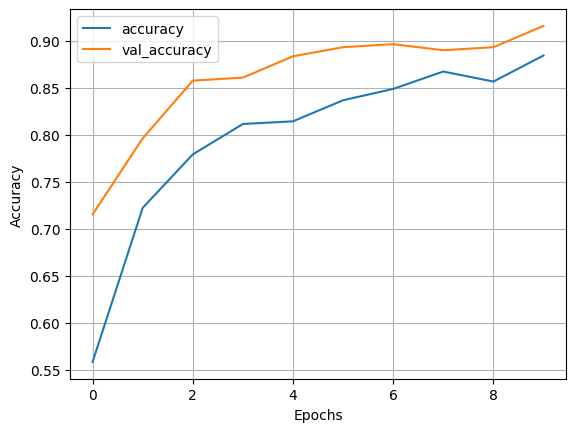

In [ ]:
# Plot results
def plot_history(history):
    metrics = ['accuracy', 'val_accuracy']
    progress = {k: v for k, v in history.history.items() if k in metrics}
    pd.DataFrame(progress).plot()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

plot_history(history)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 434ms/step


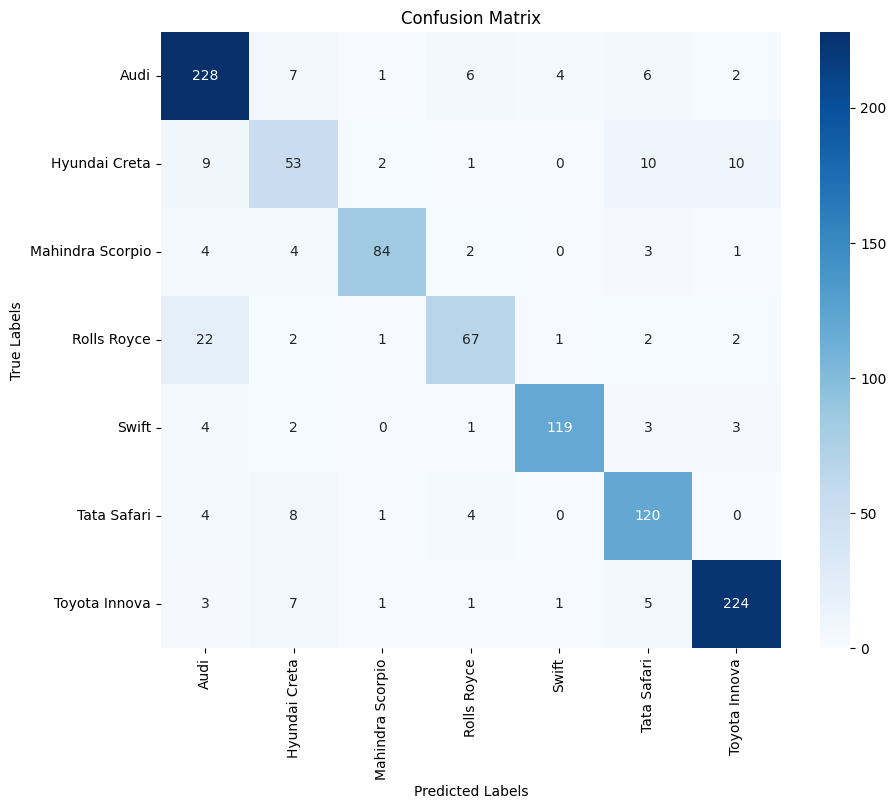

                  precision    recall  f1-score   support

            Audi       0.83      0.90      0.86       254
   Hyundai Creta       0.64      0.62      0.63        85
Mahindra Scorpio       0.93      0.86      0.89        98
     Rolls Royce       0.82      0.69      0.75        97
           Swift       0.95      0.90      0.93       132
     Tata Safari       0.81      0.88      0.84       137
   Toyota Innova       0.93      0.93      0.93       242

        accuracy                           0.86      1045
       macro avg       0.84      0.82      0.83      1045
    weighted avg       0.86      0.86      0.86      1045



In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

model = load_model('/content/drive/MyDrive/InceptionResNetV2_TL_final.keras')

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

conf_mat = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Reds',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

#classification Report (Precision, Recall, F1-Score)
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)
